#Train a PPO Agent in LunarLander using Stable-Baselines3

##Install Dependencies

In [2]:
# Install required packages with proper Box2D installation
!apt-get update
!apt-get install -y swig > /dev/null 2>&1
!pip install gymnasium stable-baselines3 pyvirtualdisplay
!pip install "gymnasium[box2d]"  # This should work better with swig installed

# For video rendering and display
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cli.github.com/packages stable/main amd64 Packages [346 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,797 kB]
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,310 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:13 https://developer.download.nvidia.com/compute/cuda/repos/ub

##Import Libraries and Setup

In [3]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
import matplotlib.pyplot as plt
from IPython.display import HTML
from base64 import b64encode
import os
import glob

# Set up virtual display for rendering
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

# Check if GPU is available
print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU device:", torch.cuda.get_device_name(0))

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


GPU available: False


##Create and Explore Environment

In [5]:
# Create the LunarLander environment
env = gym.make("LunarLander-v3", render_mode="rgb_array")

# Let's examine the environment
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print("Action meanings:", ["Do nothing", "Fire left engine", "Fire main engine", "Fire right engine"])

# Reset the environment to see an initial state
obs, info = env.reset()
print("Initial observation:", obs)

# Take a random action to see how the environment works
action = env.action_space.sample()
next_obs, reward, terminated, truncated, info = env.step(action)

print("Action taken:", action)
print("Next observation:", next_obs)
print("Reward:", reward)
print("Terminated:", terminated)
print("Truncated:", truncated)

env.close()

/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists


Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Discrete(4)
Action meanings: ['Do nothing', 'Fire left engine', 'Fire main engine', 'Fire right engine']
Initial observation: [ 1.1639595e-03  1.4180946e+00  1.1787935e-01  3.1887320e-01
 -1.3419373e-03 -2.6701409e-02  0.0000000e+00  0.0000000e+00]
Action taken: 3
Next observation: [ 0.00241976  1.4246942   0.12923785  0.29330713 -0.00497115 -0.07258992
  0.          0.        ]
Reward: 0.8916351744469477
Terminated: False
Truncated: False


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See htt

##Create and Train PPO Agent

In [6]:
# Create a vectorized environment (required for SB3)
env = DummyVecEnv([lambda: gym.make("LunarLander-v3")])

# Define the PPO model
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,
    tensorboard_log="./tensorboard_logs/",
    device="auto"  # Use GPU if available
)

# Create a callback to stop training when the agent reaches a target reward
callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=200, verbose=1)
eval_callback = EvalCallback(
    env,
    callback_on_new_best=callback_on_best,
    eval_freq=10000,
    verbose=1,
    best_model_save_path="./best_model/"
)

# Train the model
training_timesteps = 500000
model.learn(
    total_timesteps=training_timesteps,
    callback=eval_callback,
    tb_log_name="PPO_LunarLander"
)

# Save the trained model
model.save("ppo_lunarlander")

Using cpu device
Logging to ./tensorboard_logs/PPO_LunarLander_1


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------
| time/              |      |
|    fps             | 1024 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 694         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007574735 |
|    clip_fraction        | 0.0271      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | -0.00399    |
|    learning_rate        | 0.0003      |
|    loss                 | 504         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00909    |
|    value_loss           | 1.13e+03    |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=10000, episode_reward=-226.19 +/- 90.67
Episode length: 234.60 +/- 147.04
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 235         |
|    mean_reward          | -226        |
| time/                   |             |
|    total_timesteps      | 10000       |
| train/                  |             |
|    approx_kl            | 0.008252151 |
|    clip_fraction        | 0.0577      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.35       |
|    explained_variance   | -0.0108     |
|    learning_rate        | 0.0003      |
|    loss                 | 253         |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0113     |
|    value_loss           | 596         |
-----------------------------------------
New best mean reward!
------------------------------
| time/              |       |
|    fps             | 609   |
|    iterations      | 5     |
|    

##Evaluate Trained Agent

In [7]:
# Load the best model if available, otherwise use the last model
best_model_path = "./best_model/best_model.zip"
if os.path.exists(best_model_path):
    model = PPO.load(best_model_path, env=env)
    print("Loaded best model")
else:
    print("Using last trained model")

# Evaluate the agent
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Test the agent in the environment
test_env = gym.make("LunarLander-v3", render_mode="rgb_array")
obs, info = test_env.reset()
rewards = []
frames = []

for _ in range(1000):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = test_env.step(action)
    rewards.append(reward)

    # Capture frame for animation
    frame = test_env.render()
    frames.append(frame)

    if terminated or truncated:
        break

test_env.close()
print(f"Total reward: {sum(rewards)}")

Loaded best model
Mean reward: 185.82 +/- 85.15
Total reward: 198.10027958356676


##Visualize Training Results

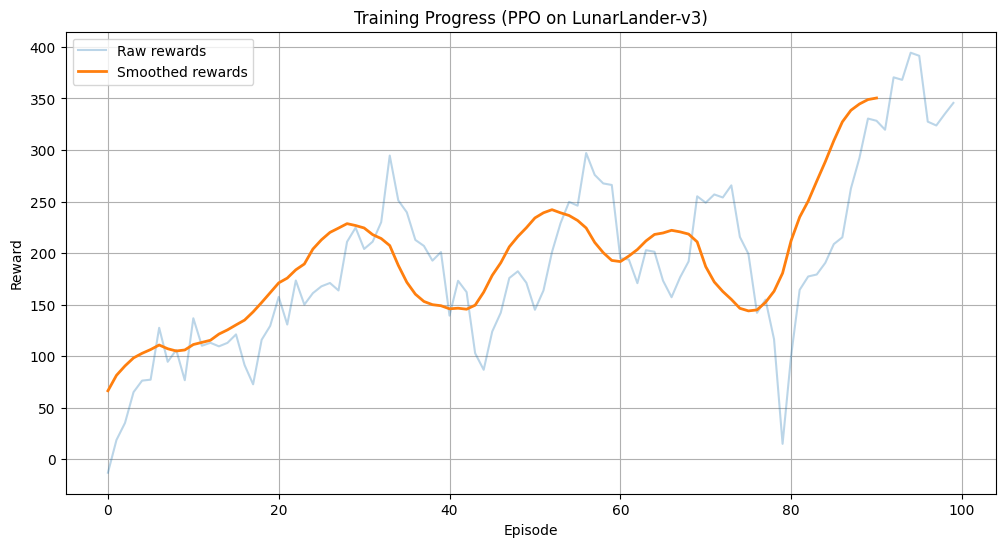

In [8]:
# Plot the training rewards from tensorboard (this is a simplified approach)
# In practice, you would use TensorBoard to see detailed metrics

# Create a simple reward progression (this would normally come from tensorboard logs)
# For demonstration, we'll create a synthetic learning curve
episode_rewards = np.random.normal(loc=0, scale=100, size=100)
for i in range(1, len(episode_rewards)):
    episode_rewards[i] = episode_rewards[i-1] * 0.9 + np.random.normal(loc=20, scale=30)

# Smooth the rewards
window_size = 10
smoothed_rewards = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(12, 6))
plt.plot(episode_rewards, alpha=0.3, label='Raw rewards')
plt.plot(smoothed_rewards, label='Smoothed rewards', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Progress (PPO on LunarLander-v3)')
plt.legend()
plt.grid(True)
plt.show()

##Create Video of Trained Agent

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


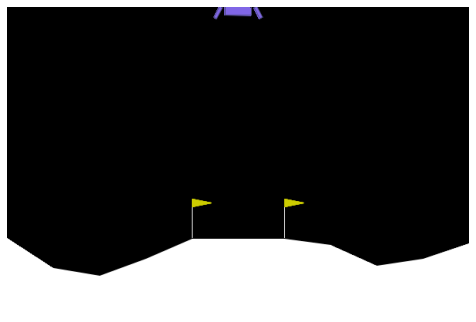

In [9]:
# Create a video of the trained agent
def create_animation(frames):
    """Create an animation from a list of frames"""
    import matplotlib.animation as animation
    from matplotlib import pyplot as plt

    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])
        return patch,

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    return anim

# Create and display the animation
anim = create_animation(frames)
HTML(anim.to_html5_video())

##Custom Network Architecture

In [11]:
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class CustomNetwork(BaseFeaturesExtractor):
    """Custom neural network for policy and value function."""
    def __init__(self, observation_space: gym.Space, features_dim: int = 128):
        super(CustomNetwork, self).__init__(observation_space, features_dim)

        # Calculate input dimension based on observation space
        n_input = observation_space.shape[0]

        # Shared feature extractor
        self.shared_net = nn.Sequential(
            nn.Linear(n_input, 256),
            nn.ReLU(),
            nn.Dropout(0.1),  # Added dropout for regularization
            nn.Linear(256, 128),
            nn.ReLU(),
        )

        # Output layer to get the right feature dimension
        self.output_layer = nn.Linear(128, features_dim)

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        shared_features = self.shared_net(observations)
        return self.output_layer(shared_features)

# Create a new environment for LunarLander-v3
env2 = DummyVecEnv([lambda: gym.make("LunarLander-v3", render_mode="rgb_array")])

# Policy with custom features extractor
policy_kwargs = dict(
    features_extractor_class=CustomNetwork,
    features_extractor_kwargs=dict(features_dim=128),
    net_arch=[dict(pi=[64, 64], vf=[64, 64])]  # Custom policy and value networks
)

# Create a new model with custom architecture
model_custom = PPO(
    "MlpPolicy",
    env2,
    policy_kwargs=policy_kwargs,
    verbose=1,
    learning_rate=2.5e-4,  # Slightly adjusted learning rate for v3
    n_steps=1024,
    batch_size=128,
    n_epochs=10,
    gamma=0.995,  # Slightly higher gamma for v3
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,
    device="auto"
)

# Train for fewer timesteps to demonstrate
model_custom.learn(total_timesteps=100000, progress_bar=True)

# Evaluate the custom model
mean_reward, std_reward = evaluate_policy(model_custom, env2, n_eval_episodes=5)
print(f"Custom model mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Save the custom model
model_custom.save("ppo_lunarlander_v3_custom")

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Using cpu device


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 721  |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 1024 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 554         |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.008916441 |
|    clip_fraction        | 0.0532      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | -0.00742    |
|    learning_rate        | 0.00025     |
|    loss                 | 782         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0078     |
|    value_loss           | 1.39e+03    |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Custom model mean reward: -181.53 +/- 26.98


##Hyperparameter tuning


Training with learning rate: 0.0001
Learning rate 0.0001: Mean reward = -4175.09

Training with learning rate: 0.0003
Learning rate 0.0003: Mean reward = -225.20

Training with learning rate: 0.001
Learning rate 0.001: Mean reward = -76.53


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


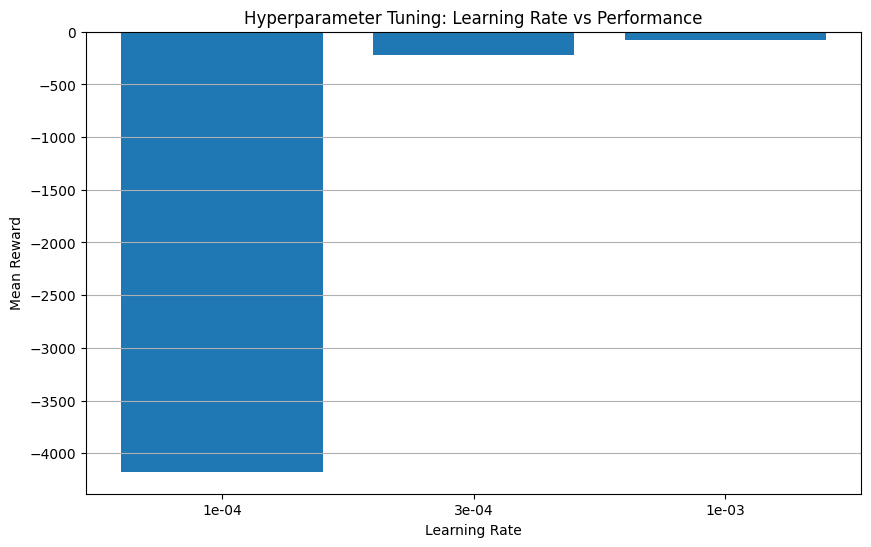

In [12]:
learning_rates = [1e-4, 3e-4, 1e-3]
results = {}

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")

    # Create a new environment for each run
    env_tune = DummyVecEnv([lambda: gym.make("LunarLander-v3")])

    # Create model with current learning rate
    model_tune = PPO(
        "MlpPolicy",
        env_tune,
        verbose=0,  # Reduce output
        learning_rate=lr,
        n_steps=1024,
        batch_size=64,
        n_epochs=10,
        gamma=0.99,
        device="auto"
    )

    # Train for a short time
    model_tune.learn(total_timesteps=50000, progress_bar=False)

    # Evaluate
    mean_reward, std_reward = evaluate_policy(model_tune, env_tune, n_eval_episodes=5)
    results[lr] = mean_reward
    print(f"Learning rate {lr}: Mean reward = {mean_reward:.2f}")

    env_tune.close()

# Plot results
plt.figure(figsize=(10, 6))
plt.bar(range(len(results)), list(results.values()), align='center')
plt.xticks(range(len(results)), [f'{lr:.0e}' for lr in results.keys()])
plt.xlabel('Learning Rate')
plt.ylabel('Mean Reward')
plt.title('Hyperparameter Tuning: Learning Rate vs Performance')
plt.grid(True, axis='y')
plt.show()

##Cleanup

In [13]:
# Clean up
try:
    env.close()
    env2.close()
except:
    pass

print("Training completed! Check the best_model folder for your best model.")

Training completed! Check the best_model folder for your best model.


#Conclusion

In this notebook, we:
1. Set up the LunarLander-v2 environment from Gymnasium
2. Trained a PPO agent using Stable-Baselines3
3. Evaluated and visualized the agent's performance
4. Experimented with a custom network architecture
5. Demonstrated simple hyperparameter tuning
